<a href="https://colab.research.google.com/github/andreeadeac22/IFT6760H20/blob/master/Copy_of_IFT6760_H20_A1_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This synthetic MDP has no particular meaning except that it produces pretty plot. It is inspired from [Dadashi & al. (2019)](http://proceedings.mlr.press/v97/dadashi19a.html).

Note: we will be using [JAX](https://jax.readthedocs.io/en/latest/) instead of Numpy because we will later make use of the automatic differentiation feature. 
Because JAX is meant to work best when the code is properly [*jitted*](https://en.wikipedia.org/wiki/Just-in-time_compilation) (which I didn't do for simplicity), some sections may run slower than a pure Numpy implementation. It shouldn't be a problem for the problems that we are working with (order of few seconds max). If you are impatient, feel free to use the [@jit](https://jax.readthedocs.io/en/latest/jax.html#just-in-time-compilation-jit) decorator where appropriate.

In [0]:
import jax.numpy as np
from jax.config import config
config.update("jax_enable_x64", True)

def synthetic_mdp():
  P = np.array([[[0.75 , 0.25 ], [0.2 , 0.8 ]],
                [[0.99, 0.01], [0.8, 0.2]]])
  mdp_R = np.array(([[-0.5, -0.25 ],
                [ 0.5 ,  0.25 ]]))
  return P, mdp_R, 0.9

The method of successive approximation provides us with a generic template for all of our algorithms. In the following, we will use:

In [0]:
def generate_iterates(xinit, operator, termination_condition):
    x, xprev = operator(xinit), xinit
    #print(x)
    yield x
    while not termination_condition(xprev, x):
        x, xprev = operator(x), x
        yield x

def successive_approximation(xinit, operator=lambda x: x, termination_condition=lambda xprev, x: False):
    for iterate in generate_iterates(xinit, operator, termination_condition):
      pass
    return iterate

We define a generic termination condition for successive approximation based on the Euclidean distance between two iterates. 

In [0]:
def default_termination(xprev, x, epsilon=1e-8):
  return np.linalg.norm(xprev - x) < epsilon

# Policy Evaluation

We start by implementing the policy evaluation operator. Refer to the section on vector notation in the course notes or read Puterman (1994) for references. 
In general, many of these operations can be written consicely by using [np.einsum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html). For an overview of Einstein notation, see this [blogpost](https://rockt.github.io/2018/04/30/einsum) by Tim Rocktäschel.

In [0]:
def make_policy_evaluation_operator(P, R, discount, policy):
  def policy_evaluation_operator(v):  
    p_pi = np.einsum('ijk,ji->jk', P, policy)
    discounted_pv = discount * np.einsum('ij,j->i', p_pi, v)
    r_pi = np.einsum('ij, ij -> i', policy, R)
    return np.add(r_pi, discounted_pv)
  return policy_evaluation_operator

In [5]:
mdp = synthetic_mdp()
P, mdp_R, discount = mdp
nstates, nactions = P.shape[-1], P.shape[0]

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


A good sanity check to see if our policy evaluation method is to use a reward function which is $1$ everywhere. In the discounted setting, we have that the expected return should be equal to $1/(1- 
\gamma)$.

In [0]:
reward_all_ones = np.ones((nstates, nactions))
uniform_policy = np.ones((nstates, nactions))/nactions

policy_evaluation_operator = make_policy_evaluation_operator(P, reward_all_ones, discount, uniform_policy)
solution = successive_approximation(np.zeros((nstates,)), policy_evaluation_operator, default_termination)

The following should return true:

In [7]:
np.allclose(solution, [1/(1-discount)]*nstates)

DeviceArray(True, dtype=bool)

Now we can also make sure that the solution found by succesive approximation matches the closed-form solution which we would obtain using a direct method. 

In [0]:
def direct_policy_evaluation(P, R, discount, policy):
  # Add your implementation below. Avoid explicit matrix inverses
  # You should be able to do this in 3 lines or less.
  p_pi = np.einsum('ijk,ji->jk', P, policy)
  discounted_p_pi = discount * p_pi
  a = np.subtract(np.identity(P.shape[-1]), discounted_p_pi)

  r_pi = np.einsum('ij, ij -> i', policy, R)
  return np.linalg.solve(a, r_pi)

In [0]:
solution = direct_policy_evaluation(P, reward_all_ones, discount, uniform_policy)

This should once again return true: 

In [10]:
np.allclose(solution, [1/(1-discount)]*nstates)

DeviceArray(True, dtype=bool)

## Projected Policy Evaluation Operator

We have seen that the projected policy evaluation equations can be solved either in closed form or iteratively using the projected (Bellman) policy evaluation operator. 

Because the projection is taken with respect to a weighted Euclidean distance, you have to compute the entries of the diagonal matrix $X$ by solving for the stationary distribution of the given policy in the MDP. 

Remember that a stationary distribution $x$ must satisfy $x^\top P = x^\top$, 
where $x^\top \mathbf{1} = 1 \in \mathbb{R}^{|\mathcal{S}|}$ and $P \in \mathbb{R}^{|\mathcal{S}| \times |\mathcal{S}|}$. Therfore, $x^\top$ is a left eigenvector of $P$. By the [Perron-Frobenius theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem), we know that there exists a eigenvalue of maximum modulus which is a real positive number: the Perron root. For stochastic matrices, the Perron root (the spectral radis) is equal to 1. Furthermore, the eigenvector associated with the Perron root (the Perron vector) has only positive components. 

You can use numpy to find the eigendecomposition of the stochastic matrix, isolate the Perron vector (through the Perron root) and normalize the resulting vector so that it sums up to one. 

Alternatively, you could also choose to view the problem of finding a solution to $x^\top P = x^\top$ as a fixed-point problem and use the above ``successive_approximation`` function with the appropriate operator. Note however that the zero vector is a trivial solution of this problem, and you should make sure not to initialize from this point.

In the following, implement a function to compute the stationary distribution for a given transition matrix:

In [0]:
def stationary_distribution(P):
  # Compute stationary distribution here
  w, v = np.linalg.eig(P.T)
  for i, e in enumerate(w):
    if np.isclose(e, 1.):
      return v[:,i] / np.sum(v[:,i])

We can now use this function to pre-compute the stationary distribution and use it to form the projected policy evaluation operator:

In [0]:
def make_pvi_operator(P, R, discount, policy, phi):
  # Compute A and b matrices here
  p_pi = np.einsum('ijk,ji->jk', P, policy)

  x = stationary_distribution(p_pi) 
  phitx = np.einsum('ij,jk->ik', phi.T, np.diag(x))

  a = np.subtract(np.identity(P.shape[-1]), discount * p_pi)
  phitx_a = np.einsum('ij, jk->ik', phitx, a)
  A = np.einsum('ij, jk->ik', phitx_a, phi)

  r_pi = np.einsum('ij, ij -> i', policy, R)
  b = np.einsum('ij, j->i', phitx, r_pi)

  def pvi_operator(w):
    # Compute projection here, without forming matrix inverse explicitely
    phitx_phi = np.einsum('ij, jk->ik', phitx, phi)
    c_wk = np.einsum('ij, j->i', phitx_phi, w)

    A_wk = np.einsum('ij, j->i', A, w)

    rhs = np.subtract( np.add(c_wk, b), A_wk)
    return np.linalg.solve(phitx_phi, rhs)
  return pvi_operator  

As a sanity check, we can verify that we obtain the exact solution when using *one-hot*  (tabular) features.

In [0]:
one_hot_features = np.eye(nstates)

In [0]:
pvi_operator = make_pvi_operator(P, reward_all_ones, discount, uniform_policy, one_hot_features)
solution = successive_approximation(np.zeros(nstates), pvi_operator, default_termination)

Because we used the reward function which is one everywhere, we should also find that the expected return is $1/(1-\gamma)$. 

This test should also return true:

In [15]:
np.allclose(one_hot_features @ solution, [1/(1-discount)]*nstates)

DeviceArray(True, dtype=bool)

A non-iterative alternative to the above PVI algorithm is simply to solve for the projected policy evaluation equations using a direct method. Implement the projected counterpart to the above ``direct_policy_evaluation`` method.

In [0]:
def direct_projected_policy_evaluation(P, R, discount, policy, phi):
  # Compute A and b matrices here
  p_pi = np.einsum('ijk,ji->jk', P, policy)

  x = stationary_distribution(p_pi) 
  phitx = np.einsum('ij,jk->ik', phi.T, np.diag(x))

  a = np.subtract(np.identity(P.shape[-1]), discount*p_pi)
  phitx_a = np.einsum('ij, jk->ik', phitx, a)
  A = np.einsum('ij, jk->ik', phitx_a, phi)

  r_pi = np.einsum('ij, ij -> i', policy, R)
  b = np.einsum('ij, j->i', phitx, r_pi)
  return np.linalg.solve(A, b)

In [0]:
solution = direct_projected_policy_evaluation(P, reward_all_ones, discount, uniform_policy, one_hot_features)

In [18]:
np.allclose(one_hot_features @ solution, [1/(1-discount)]*nstates)

DeviceArray(True, dtype=bool)

### Bertsekas Bound

Verify that the bound in proposition 6.3.1 for Bertsekas holds. Use the direct of iterative policy evaluation methods to compute all the terms in the bound. 

Test for the synthetic MDP with a uniform policy and tabular features. Then generate a random full-rank matrix of features and repeat the exercise.

In [45]:
# verifying Bertsekas bound


solution = direct_policy_evaluation(*mdp, uniform_policy)
projected_solution = direct_projected_policy_evaluation(*mdp, uniform_policy, one_hot_features)

lhs = np.subtract(solution, projected_solution)
squared = np.einsum('i, i->i', lhs, lhs)
print(np.sqrt(np.sum(squared)))


0j


# Optimality Equations

As usual, I advise you to use [np.einsum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html) to implement the following optimality operators. Note that in all cases, the following operators act on vectors $v \in \mathbb{R}^{|\mathcal{S}|}$ and not on Q-factors $Q \in \mathbb{R}^{|\mathcal{S}|\times|\mathcal{A}|}$. 

In [0]:
def make_bellman_optimality_operator(P, R, discount):
  def bellman_optimality_operator(v):
    # This should be a one-liner
    return np.max(np.add(R, discount * np.einsum('ijk,k->ji', P, v)), axis=1)
  return bellman_optimality_operator

Now do the same thing but where you use the [soft-max](https://en.wikipedia.org/wiki/Smooth_maximum) (smooth maximum) instead of the *hard* one. You can use the built-in implementations of the soft-max function for more stability. See [Rust (1996)](https://doi.org/10.1016/s1574-0021(96)01016-7) for reference

In [0]:
from jax.experimental.stax import softmax
from scipy.special import logsumexp

def make_smooth_bellman_optimality_operator(P, R, discount, temperature):
  def smooth_bellman_optimality_operator(v):
    # This should be a one-liner
    
    #softmaxed = softmax(1./temperature * v)
    #softmaxed_v = np.einsum('i,i->i', softmaxed, v)
    #r_pv = np.sum(np.add(R, discount * np.einsum('ijk,k->ji', P, softmaxed_v)), axis=-1)
    pv = np.einsum('ijk,k->ji', P, v)
    temp_lv = 1./temperature * np.add(R, discount * pv)  
    #print("temp_lv ", temp_lv)
    max_col = np.reshape(np.max(temp_lv, axis=1), newshape=(nstates, 1))
    #print("max_col ", max_col)
    max_mat = np.repeat(max_col, repeats=temp_lv.shape[0], axis=1)
    shift_templv =  temp_lv - max_mat
    #print("shift ", shift_templv)
    #s = np.max(temp_lv) + np.log(np.sum(np.exp(shift_templv), axis=1))
    s = np.max(temp_lv, axis=1) + np.log(np.sum(np.exp(shift_templv), axis=1))
    #print("s ", s)
    #ss = logsumexp(r_pv, axis=-1, b=1./temperature)
    #print("ss ", ss)
    #print("new s ", temperature * s)
    return temperature * s
  return smooth_bellman_optimality_operator

We can apply the same sanity check for the optimality equations and use a reward function where all components are set to $1$. The following loop goes over the *hard* and smooth optimality operators and verifies that we recover the optimal value function in all cases:



In [21]:
default_temperature = 1e-5

hard_operator = make_bellman_optimality_operator(P, reward_all_ones, discount)
smooth_operator = make_smooth_bellman_optimality_operator(P, reward_all_ones, discount, default_temperature)

for operator in [hard_operator, smooth_operator]:
  solution = successive_approximation(np.zeros((nstates,)), operator, default_termination)
  print(np.allclose(solution, [1/(1-discount)]*nstates))

True
True


Equipped with policy evaluation methods from above, we can also easily define a policy evaluation operator. Note that this time, the operator takes a policy (not a value vector) and returns an improved policy.

In [0]:
def make_policy_iteration_operator(P, R, discount):
  def policy_iteration_operator(policy):
    v = direct_policy_evaluation(P, R, discount, policy)
    argmax_a = np.argmax(np.add(R, discount * np.einsum('ijk,k->ji', P, v)), axis=1)
    return np.eye(P.shape[-1])[argmax_a]
  return policy_iteration_operator

We also have to define a new termination condition, suited to the fact that we iterate over deterministic policies:

In [0]:
def policy_iteration_termination(policy_prev, policy):
  return np.allclose(policy_prev, policy)

In a somewhat redundant exercise, you can also define the smooth counterpart to the usual policy iteration by replacing the argmax with the soft-argmax. You can also use a built-in implementation for better numerical stability.

In [0]:
from jax.nn import softmax
def make_smooth_policy_iteration_operator(P, R, discount, temperature):
  def smooth_policy_iteration_operator(policy):
    v = direct_policy_evaluation(P, R, discount, policy)

    pv = np.einsum('ijk,k->ji', P, v)

    temp_lv = 1./temperature * np.add(R, discount*pv)
    #normalized = np.exp(temp_lv - temp_lv.max())
    #new_policy = temp_lv / np.sum(temp_lv, axis=0)
    #return temp_lv / np.sum(temp_lv, axis=0)
    return  softmax(temp_lv)
  return smooth_policy_iteration_operator

The method of sucessive approximation applied to these operators returns a policy as output, if we want to verify that they are indeed optimal, we now need to re-use our policy evaluation code to compute the associated value function.

The following should return true twice:

In [25]:
policy_iteration_operator = make_policy_iteration_operator(P, reward_all_ones, discount)
policy = successive_approximation(np.zeros((nstates, nactions)), policy_iteration_operator, policy_iteration_termination)
solution = direct_policy_evaluation(P, reward_all_ones, discount, policy)
print(np.allclose(solution, [1/(1-discount)]*nstates))

True


In [26]:
smooth_policy_iteration_operator = make_smooth_policy_iteration_operator(P, reward_all_ones, discount, default_temperature)
policy = successive_approximation(np.zeros((nstates, nactions)), smooth_policy_iteration_operator, default_termination)
solution = direct_policy_evaluation(P, reward_all_ones, discount, policy)
print(np.allclose(solution, [1/(1-discount)]*nstates))

True


## Newton-Kantorovich

In order to implement Newton-Kantorovich for the smooth Bellman operator, we first use the analytical expression for its Gateaux derivative. See [Rust (1996)](https://doi.org/10.1016/s1574-0021(96)01016-7) for reference

In [0]:
from jax.experimental.stax import softmax

def make_gateaux_derivative(P, R, discount, temperature):
  """ Returns the Gateaux derivative at v of the smooth Bellman operator
  """
  def gateaux_at(v):
    """ Binds v into a function computing the gateaux derivative
    """
    pv = np.einsum('ijk,k->ji', P, v)
    d = softmax(1./temperature * np.add(R, discount*pv))
    def gateaux_direction(w):
      """ Compute the Gateaux derivative at v in the direction of w
      """
      # Add your code here
      pw = np.einsum('ijk,k->ji', P, w)
      d_pw = np.einsum('ij, ij -> i', d, pw)
      return discount * d_pw 
    return gateaux_direction
  return gateaux_at

We can also compute this derivative using forward-mode automatic differentiation in [JAX](https://github.com/google/jax). Under the hood, forward-mode automatic differentiation is implemented by defining the jacobian-vector for all primitive operations. This vector-jacobian product corresponds to our notion of directional derivative and the function [vjp](https://jax.readthedocs.io/en/latest/jax.html#jax.jvp) gives us that.

The following should return true:

In [28]:
from jax import jvp

v = np.ones(nstates)/nstates
w = np.array([1.,2.])

_, tangents = jvp(smooth_operator, (v, ), (w,))
deriv = make_gateaux_derivative(P, reward_all_ones, discount, default_temperature)(v)(w)

print("tangents ", tangents)
print("deriv ", deriv)
np.allclose(tangents, deriv)

tangents  [1.017 1.35 ]
deriv  [1.017 1.35 ]


DeviceArray(True, dtype=bool)

Equipped with the Gateaux derivative, we can then implement the Newton-Kantorovich algorithm in a generic way. Because Newton-Kantorovich involves taking an inverse, we need to be careful as to how we implement this step. A naive approach would consists in forming the full Jacobian and directly calling [np.linalg.solve](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html). But we can do better! Using a classical iterative method, all we require is to be able to take matrix-vector products, or more abstractly, to be able to apply an operator to any vector.  

In the following, you have to build such method by defining the appropriate operator. Note that this operator has the same form as the policy evalution one, but for $I - A$ and where $A$ need not be a stochastic matrix (but we still need the spectral radius $\sigma(I - A) < 1$).

In [0]:
def basic_iterative_solver(A, b):
  """ Solves $Ax = b$, assuming that the spectral radius of $I - A$ is 
  strictly less than 1. We assume that $A$ is a callable $A(v)$.
  """
  def operator(x):
    """ Basic iterative step without preconditioning 
    (you can add preconditioning if you feel like)

    This is what you would obtain by writting the Neumann series epxansion of 
    $A$ recursively. 
    """
    # Add your code here. This is a one-liner
    return b + x - A(x)
  return successive_approximation(np.zeros(b.shape), operator, default_termination)

Now refer to the course notes or [Rust (1996)](https://doi.org/10.1016/s1574-0021(96)01016-7) for the general structure of Newton-Kantorovich iterations and implement the corresponding operator:

In [0]:
def make_newton_kantorovich(operator, gateaux_derivative):
  """ Newton-Kantorovich method with matrix-free iterative solver
  """
  def newton_kantorovich(v):
    # One-liner using the above basic_iterative_solver
    w =  v - operator(v)
    A = gateaux_derivative(v)
    gd = basic_iterative_solver(A, w)
    return np.subtract(v, gd)
  return newton_kantorovich

As usual, we verify that we find the optimal value function when all rewards are one. The following should return true:

In [31]:
smooth_operator = make_smooth_bellman_optimality_operator(P, reward_all_ones, discount, default_temperature)
gateaux_derivative = make_gateaux_derivative(P, reward_all_ones, discount, default_temperature)

newton_kantorovich_operator = make_newton_kantorovich(smooth_operator, gateaux_derivative)
solution = successive_approximation(np.zeros((nstates,)), newton_kantorovich_operator, default_termination)
print(np.allclose(solution, [1/(1-discount)]*nstates))

True


# Trajectories in the Polytope

Sample $1000$ policies at random. Using either the closed-form expression or via successive approximation, compute the value function corresponding to each of them. Plot the mapping $\pi \mapsto v_\pi$ using [matplotlib.pyplot.scatter](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html) (the x axis is $v(s_0)$ and the y axis is $v(s_1))$. Enumerate all possible deterministic policies, compute their value functions and plot them. 

To do so, you may want to define a new function which generalizes the above ``direct_policy_evaluation`` to the case where you have a batch of policies (let's say as a multidimensional array of size $n \times |\mathcal{S}| \times |\mathcal{A}|$ where $n$ is the number of policies). This can be done easily by just changing the indices in the Einstein summation since [numpy.linalg.solve](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) supports *batched*  linear systems out-of-the-box.


vs  [-0.82894636  1.02505688]
policies  [[9.99698507e-01 3.01493209e-04]
 [9.49028389e-01 5.09716109e-02]]


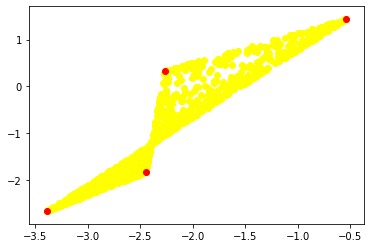

In [32]:
def batch_policy_evaluation(P, R, discount, policies):

  discounted_p_pi = discount * np.einsum('ijk,lji->ljk', P, policies)
  a = np.subtract(np.identity(P.shape[-1]), discounted_p_pi)

  rpi = np.einsum('ij, lij -> li', R, policies)
  return np.linalg.solve(a, rpi)


import numpy.random as npr
alphas = [0.5, 0.5]
policies = npr.dirichlet(alpha=alphas, size=(1000, nstates))
#policies = policies / np.sum(policies, axis=-1, keepdims=True)

import matplotlib.pyplot as plt

vs = batch_policy_evaluation(*mdp, policies)

random_int = npr.randint(0,1000)

print("vs ", vs[random_int,:])
print("policies ", policies[random_int,:])

x = vs[:,0]
y = vs[:,1]
#xlim_min = min(x)
#xlim_max = max(x)
#ylim_min = min(y)
#ylim_max = max(y)
#eps = 1e-1
#plt.xlim(xlim_min-eps, xlim_max+eps)
#plt.ylim(ylim_min-eps, ylim_max+eps)
plt.scatter(x, y, c='yellow')

def fill(all_lists, part_list, i):
  if i == nstates:
    all_lists.append(part_list)
  else:
    for j in range(nactions):
      cur_list = list(part_list)
      cur_list.append(j)
      fill(all_lists, cur_list, i + 1)

deterministic_policies= []
fill(deterministic_policies, [], 0)

det_policies = []
for pol in deterministic_policies:
  det_policies += [np.eye(P.shape[-1])[pol]]

det_policies = np.stack(det_policies)

det_vs = batch_policy_evaluation(*mdp, det_policies)
det_x = det_vs[:,0]
det_y = det_vs[:,1] 

plt.scatter(det_x, det_y, c='red')
plt.show()


In [33]:
print(det_vs)

[[-0.54455446  1.43564356]
 [-3.38516746 -2.66746411]
 [-2.26643599  0.32871972]
 [-2.44571773 -1.84258142]]


Overlay (with a different color) the trajectories taken by value iteration, smooth value iteration and Newton-Kantorovich. To do so, compute the greedy policy for each iterate and solve (policy evaluation) for its corresponding value function. Plot all such points.

To get those iterates, you can call the function ``generate_iterates`` directly and consume the generator using the ``list()`` keyword:

[-3.38516746 -2.66746411]


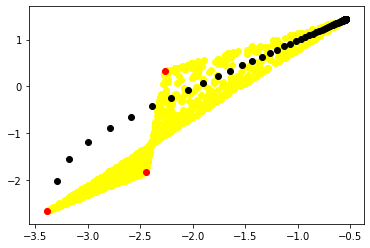

Done 1


In [34]:
# Example:
starting_v = np.array( [-3.38516746, -2.66746411])
print(starting_v)
bellman_optimality_operator = make_bellman_optimality_operator(*mdp)
trajectory = generate_iterates(starting_v, bellman_optimality_operator, default_termination)

px = []
py = []

for e in list(trajectory):
  #print("e ", e)
  #rgmax_a = np.argmax(np.add(R, discount * np.einsum('ijk,k->ji', P, e)), axis=1)
  #pol = np.eye(P.shape[-1])[argmax_a]
  #policy_evaluation_operator = make_policy_evaluation_operator(*mdp, pol)
  #pol_v = policy_evaluation_operator(e)
  #pol_v = direct_policy_evaluation(*mdp, pol)
  px.append(e[0])
  py.append(e[1])

plt.scatter(x, y, c='yellow')
plt.scatter(det_x, det_y, c='red')
plt.scatter(px, py, c='black')
plt.show()

print("Done 1")

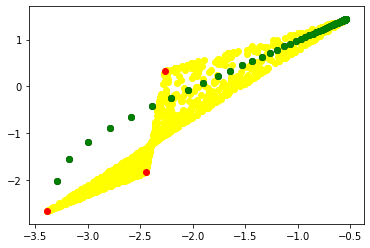

Done 2


In [35]:
smooth_bellman_optimality_operator = make_smooth_bellman_optimality_operator(*mdp, default_temperature)
smoothtrajectory = generate_iterates(starting_v, smooth_bellman_optimality_operator, default_termination)

smooth_x = []
smooth_y = []
for e in list(smoothtrajectory):
  #print("e ", e)
  #argmax_a = np.argmax(np.add(R, discount * np.einsum('ijk,k->ji', P, e)), axis=1)
  #pol = np.eye(P.shape[-1])[argmax_a]
  #pol_v = direct_policy_evaluation(*mdp, pol)
  smooth_x.append(e[0])
  smooth_y.append(e[1])

plt.scatter(x, y, c='yellow')
plt.scatter(det_x, det_y, c='red')
plt.scatter(px, py, c='black')
plt.scatter(smooth_x, smooth_y, c='green')
plt.show()

print("Done 2")

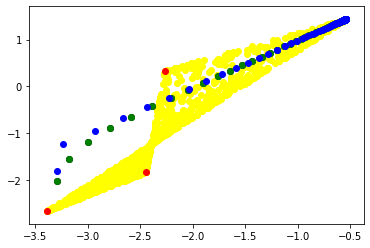

Done 3


In [36]:
smooth_bellman_optimality_operator = make_smooth_bellman_optimality_operator(*mdp, default_temperature)
gateaux_derivative = make_gateaux_derivative(*mdp, default_temperature)
newton_kantorovich_operator = make_newton_kantorovich(smooth_bellman_optimality_operator, gateaux_derivative)
ntrajectory = generate_iterates(starting_v, newton_kantorovich_operator, default_termination)

nx = []
ny = []

for e in list(ntrajectory):
  #print("e ", e)
  #argmax_a = np.argmax(np.add(R, discount * np.einsum('ijk,k->ij', P, e)), axis=1)
  #pol = np.eye(P.shape[-1])[argmax_a]
  #policy_evaluation_operator = make_policy_evaluation_operator(*mdp, new_pol)
  #pol = policy_evaluation_operator(e)
  #pol_v = direct_policy_evaluation(*mdp, pol)

  nx.append(e[0])
  ny.append(e[1])


plt.scatter(x, y, c='yellow')
plt.scatter(det_x, det_y, c='red')
plt.scatter(px, py, c='black')
plt.scatter(smooth_x, smooth_y, c='green')
plt.scatter(nx, ny, c='blue')
plt.show()

print("Done 3")

Describes what happens as you decrease the temperature in smooth value iteration and with Newton-Kantorovich and the smooth Bellman operator? Answer this question by creating a new polytope plot on which you overlays the different trajectories taken by your algorithm depending on the temperature parameter. Don't forget to add a legend. 

Also, compare the trajectories taken by policy iteration and the Newton-Kantorovich method. Do they match? Compare the iterates computed by smooth policy iteration and those of the Newton-Kantorovich method with the smooth operator using the ``generate_iterates`` function. For each iterate of smooth policy iteration (a policy), compute the associated value function and compare with the values produced by Newton-Kantorovich. Do you get the same sequence of values as if you were to run Newton-Kantorovich? 


Answers: 

Decreasing the temperature leads to values further away from the ones obtained using the (hard) value iteration. 
Smooth policy iteration seems to converge much faster. 


Done
Done
Done
Done


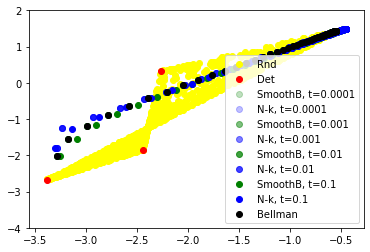

In [40]:
temperatures = [1e-4, 1e-3, 1e-2, 1e-1]

fig, ax = plt.subplots()

ax.set_ylim([-4,2])

ax.scatter(x, y, c='yellow', label='Rnd')
ax.scatter(det_x, det_y, c='red', label='Det')

low_sv =np.array([-3.38516746, -2.66746411])

for i, temp in enumerate(temperatures):
  smooth_bellman_optimality_operator = make_smooth_bellman_optimality_operator(*mdp, temp)
  smoothtrajectory = generate_iterates(low_sv, smooth_bellman_optimality_operator, default_termination)

  smooth_x = []
  smooth_y = []
  for e in list(smoothtrajectory):
    smooth_x.append(e[0])
    smooth_y.append(e[1])
  ax.scatter(smooth_x, smooth_y, c='green', alpha=(i+1)/4., label='SmoothB, t=' + str(temperatures[i]))

  gateaux_derivative = make_gateaux_derivative(*mdp, temp)
  newton_kantorovich_operator = make_newton_kantorovich(smooth_bellman_optimality_operator, gateaux_derivative)
  ntrajectory = generate_iterates(low_sv, newton_kantorovich_operator, default_termination)

  nx = []
  ny = []
  for e in list(ntrajectory):
    nx.append(e[0])
    ny.append(e[1])
  ax.scatter(nx, ny, c='blue', alpha=(i+1)/4., label='N-k, t=' + str(temperatures[i]))

  print("Done")

ax.scatter(px, py, c='black', label="Bellman")

ax.legend()
plt.show()


solution  [-2.26643599  0.32871972]
solution  [-0.54455446  1.43564356]
solution  [-0.54455446  1.43564356]


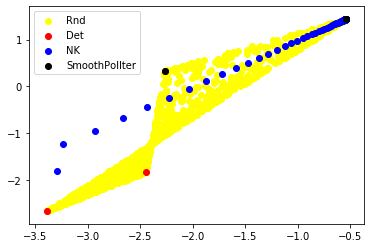

In [39]:
smooth_policy_iteration_operator = make_smooth_policy_iteration_operator(*mdp, default_temperature)
policies = generate_iterates(np.zeros((nstates, nactions)), smooth_policy_iteration_operator, default_termination)

spol_x = []
spol_y = []

fig, ax = plt.subplots()

for pol in list(policies):
  solution = direct_policy_evaluation(*mdp, pol)
  print("solution ", solution)
  spol_x.append(solution[0])
  spol_y.append(solution[1])


smooth_bellman_optimality_operator = make_smooth_bellman_optimality_operator(*mdp, default_temperature)
gateaux_derivative = make_gateaux_derivative(*mdp, default_temperature)
newton_kantorovich_operator = make_newton_kantorovich(smooth_bellman_optimality_operator, gateaux_derivative)
ntrajectory = generate_iterates(low_sv, newton_kantorovich_operator, default_termination)

nx = []
ny = []

for e in list(ntrajectory):
  nx.append(e[0])
  ny.append(e[1])


ax.scatter(x, y, c='yellow', label='Rnd')
ax.scatter(det_x, det_y, c='red', label='Det')
ax.scatter(nx, ny, c='blue', label='NK')
ax.scatter(spol_x, spol_y, c='black', label='SmoothPolIter')

ax.legend()
plt.show()
